In [1]:

import numpy as np
import matplotlib.pyplot as plt
from collections import deque



### OFC Model Implementation
This notebook provides a minimalistic implementation of the OFC (Olami-Feder-Christensen) model, often used in modeling earthquake dynamics.

Key components of this model include:
- **Threshold stress** for each site, which determines when it "fails."
- **Dissipation parameter (alpha)**, which controls how stress is redistributed after a failure.
- **Lattice structure** that represents the spatial distribution of stress levels across sites.

The model is initialized with random stress values at each site, and sites with stress values exceeding the threshold trigger stress redistribution to neighboring sites.


In [7]:

class OFC:
    def __init__(self, threshold, alpha, lattice_size, rng_seed=None):
        """Initialize OFC model with parameters and random lattice stress values."""
        # Seed for reproducibility
        self.rng = np.random.default_rng(rng_seed)
        self.threshold = threshold
        self.alpha = alpha
        self.lattice_size = lattice_size
        # Initialize lattice with random stress values between 0 and threshold
        self.lattice = self.threshold * self.rng.random((lattice_size, lattice_size))
        self.event_history = []

    def get_neighbors(self, site):
        """Retrieve neighbors for a given site (row, col) assuming open boundary conditions."""
        neighbors = []
        if site[0] < self.lattice_size - 1:
            neighbors.append((site[0] + 1, site[1]))
        if site[1] < self.lattice_size - 1:
            neighbors.append((site[0], site[1] + 1))
        if site[0] > 0:
            neighbors.append((site[0] - 1, site[1]))
        if site[1] > 0:
            neighbors.append((site[0], site[1] - 1))
        return neighbors

    def drive_plate(self):
        """Increase stress on the lattice until failure and propagate avalanche."""
        active_sites = deque()
        max_value = np.max(self.lattice)
        active_sites.append(np.unravel_index(np.argmax(self.lattice), self.lattice.shape))
        self.lattice += (self.threshold - max_value)
        event_size = 0
        while active_sites:
            current_site = active_sites.popleft()
            if self.lattice[current_site] >= self.threshold:
                neighbors = self.get_neighbors(current_site)
                for neighbor in neighbors:
                    self.lattice[neighbor] += self.alpha * self.lattice[current_site]
                    active_sites.append(neighbor)
                self.lattice[current_site] = 0
                event_size += 1
        return event_size

    def simulate(self, num_events, transient=0):
        """Run model for a given number of events, optionally with transient steps."""
        for _ in range(transient):
            _ = self.drive_plate()
        for _ in range(num_events):
            event_size = self.drive_plate()
            self.event_history.append(event_size)
        return self.event_history



### Running the Model
Define the parameters for the OFC model, create an instance, and run a simulation. 
The simulation will store the size of each event (avalanche) for analysis.


In [8]:

# Parameters
threshold = 1.0
alpha = 0.2  # Non-conservative model; set to 0.25 for no dissipation.
lattice_size = 100
transient_steps = 10000
num_events = 5000

# Initialize and run the model
model = OFC(threshold=threshold, alpha=alpha, lattice_size=lattice_size, rng_seed=1)
event_history = model.simulate(num_events=num_events, transient=transient_steps)

print("Simulation complete. Event history recorded.")


Simulation complete. Event history recorded.



### Plotting the Event Size Distribution
Here we plot the distribution of avalanche sizes recorded during the simulation to visualize the power-law behavior often characteristic of such models.


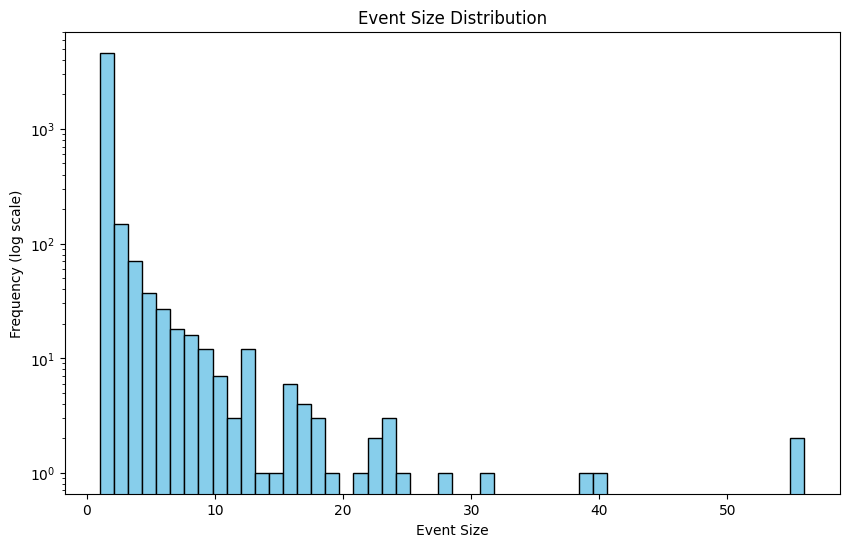

In [9]:

plt.figure(figsize=(10, 6))
plt.hist(event_history, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title('Event Size Distribution')
plt.xlabel('Event Size')
plt.ylabel('Frequency (log scale)')
plt.show()
